In [1]:
import os
import torch
from torch import nn
import torchvision as tv
import torchvision.transforms.v2 as v2
from torch.utils.data import Dataset, DataLoader, random_split
from icecream import ic
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm # Progress bar for training
from blocks import *
from utils import showDatasetSamples, displayImageGrid


from tensorboardX import SummaryWriter

from dataLoading import CIFAR10Dataset

In [2]:
class TransformableSubset(Dataset):
    """
    A wrapper class for applying transforms to a subset of a dataset since a subset doesn't have a .transform attribute
    Mainly used for applying training and val/testing transforms to different portions of the data.
    """
    def __init__(self, subset, transform=None, fullDataset=None):
        self.subset = subset
        
        if transform:
            self.transform = tv.transforms.Compose([
                transform,
                fullDataset.defaultTransform
            ])
        else:
            self.transform = CIFAR10Dataset.defaultTransform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"


def validateModelIO(model:nn.Module):
    
    print(f"Using device: {device}")

    model = model.to(device)

    print(model)
    print(f"Model has {sum(p.numel() for p in model.parameters())} parameters.")
    print(summary(model, input_size=(3, 32, 32)))

    dummy_input = torch.randn(1, 3, 32, 32, device=device, dtype=torch.float)
    output = model(dummy_input)
    assert output.size() == (1, 10), f"Expected output size (1, 10), got {output.size()}!"
    print("Test passed!")



In [4]:

fc0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Linear(in_features=144, out_features=10),
            nn.Softmax(dim=0)
        )


fc1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Linear(in_features=144, out_features=10)
        )


fc1Leaky = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            ResidualBlock(channelCount=16, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            ResidualBlock(channelCount=16, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            ResidualBlock(channelCount=16, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            ResidualBlock(channelCount=16, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            ResidualBlock(channelCount=16, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            ResidualBlock(channelCount=16, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            
            nn.Flatten(),
            nn.Linear(in_features=144, out_features=64),
            nn.LayerNorm(normalized_shape=64),
            nn.LeakyReLU(),
            
            nn.Linear(in_features=64, out_features=10),
            nn.LeakyReLU(),
        )


bottleneck1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            BottleneckBlock(in_channels=32, encode_channels=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock(in_channels=32, encode_channels=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock(in_channels=32, encode_channels=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),

            BottleneckBlock(in_channels=32, encode_channels=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),

            BottleneckBlock(in_channels=32, encode_channels=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),

            BottleneckBlock(in_channels=32, encode_channels=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),

            BottleneckBlock(in_channels=32, encode_channels=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),

            BottleneckBlock(in_channels=32, encode_channels=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(in_features=288, out_features=10)
        )

bottleneck2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            BottleneckBlock(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            nn.Flatten(),
            nn.Linear(in_features=288, out_features=10)
        )

bottleneck2R = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            BottleneckBlock2(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock2(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock2(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock2(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock2(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock2(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock2(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock2(in_channels=32, encode_channels=1, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(in_features=32, out_features=144),
            nn.LayerNorm(normalized_shape=144),
            nn.LeakyReLU(),

            nn.Linear(in_features=144, out_features=10),
            nn.LayerNorm(normalized_shape=10),
            nn.LeakyReLU(),
        )


bottleneck3 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            BottleneckBlock3(in_channels=32, encode_channels=3, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock3(in_channels=32, encode_channels=3, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock3(in_channels=32, encode_channels=3, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock3(in_channels=32, encode_channels=3, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock3(in_channels=32, encode_channels=3, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock3(in_channels=32, encode_channels=3, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock3(in_channels=32, encode_channels=3, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock3(in_channels=32, encode_channels=3, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(in_features=288, out_features=144),
            nn.LayerNorm(normalized_shape=144),
            nn.LeakyReLU(),

            nn.Linear(in_features=144, out_features=10),
            nn.LayerNorm(normalized_shape=10),
            nn.LeakyReLU(),
        )


bottleneck4 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            ResidualBlock(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            BottleneckBlock4(in_channels=32, encode_factor=4, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock4(in_channels=32, encode_factor=4, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock4(in_channels=32, encode_factor=4, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock4(in_channels=32, encode_factor=4, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock4(in_channels=32, encode_factor=4, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock4(in_channels=32, encode_factor=4, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock4(in_channels=32, encode_factor=4, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            BottleneckBlock4(in_channels=32, encode_factor=4, activation=nn.LeakyReLU()),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(in_features=288, out_features=144),
            nn.LayerNorm(normalized_shape=144),
            nn.LeakyReLU(),

            nn.Linear(in_features=144, out_features=10),
            nn.LayerNorm(normalized_shape=10),
            nn.LeakyReLU(),
        )


bottleneck4v2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            BottleneckBlock4(in_channels=32, encode_factor=4),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            BottleneckBlock4(in_channels=64, encode_factor=4),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),

            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            
            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            
            nn.Linear(in_features=128, out_features=64),
            nn.LayerNorm(normalized_shape=64),
            nn.ReLU(),
            
            nn.Linear(in_features=64, out_features=10),
            # Usually, we just send out raw logits to the loss function with no layer norms or activation functions
        )


# Remove redundant norms and activations
bottleneck4v3 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            BottleneckBlock4(in_channels=32, encode_factor=4),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            BottleneckBlock4(in_channels=64, encode_factor=4),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),

            BottleneckBlock4(in_channels=128, encode_factor=4),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            
            nn.Linear(in_features=128, out_features=64),
            nn.LayerNorm(normalized_shape=64),
            nn.ReLU(),
            
            nn.Linear(in_features=64, out_features=10),
            # Usually, we just send out raw logits to the loss function with no layer norms or activation functions
        )


# Reduce complexity
bottleneck4v4 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            BottleneckBlock4(in_channels=32, encode_factor=4),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            BottleneckBlock4(in_channels=64, encode_factor=4),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            BottleneckBlock4(in_channels=96, encode_factor=4),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock4(in_channels=96, encode_factor=4),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock4(in_channels=96, encode_factor=4),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            
            nn.Linear(in_features=384, out_features=128),
            nn.LayerNorm(normalized_shape=128),
            nn.ReLU(),
            
            nn.Linear(in_features=128, out_features=10),
            # Usually, we just send out raw logits to the loss function with no layer norms or activation functions
        )


# Aggressive downsampling before bottleblocks
bottleneck4v5 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock4(in_channels=64, encode_factor=4),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            BottleneckBlock4(in_channels=64, encode_factor=4),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),

            BottleneckBlock4(in_channels=64, encode_factor=4),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),

            nn.Flatten(),
            
            nn.Linear(in_features=256, out_features=64),
            nn.LayerNorm(normalized_shape=64),
            nn.ReLU(),
            
            nn.Linear(in_features=64, out_features=10),
            # Usually, we just send out raw logits to the loss function with no layer norms or activation functions
    )





In [4]:
fc2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Linear(in_features=144, out_features=10)
    )

validateModelIO(ResidualCNN(network=fc2, printOutsize=True))


Using device: cuda
ResidualCNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ResidualBlock2(
      (activation): ReLU()
      (c1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (c2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (residualNormalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, 

### Calculate mean and stdev for normalization of dataset

In [5]:
autoAugmentCIFAR = tv.transforms.Compose([
    v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
])


preNormalizationTransform = tv.transforms.Compose([
    # CIFAR10Dataset.defaultTransform,
    # Add other transforms here
    autoAugmentCIFAR,
])

# Create dataset instances
fullDataset = CIFAR10Dataset(rootDirectory='cifar-10', csvFilename='trainLabels.csv', dataFolder='train', transform=preNormalizationTransform)
TRAIN_DATASET, VALIDATION_DATSET, TEST_DATSAET = random_split(fullDataset, [0.8, 0.1, 0.1])

BATCH_SIZE = 256
trainLoader = DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE, shuffle=False)

mean = 0.
std = 0.
for images, _ in trainLoader:
    
    batchSamples = images.size(0)
    # Get an image view of shape (batchSamples, C, H*W) which is faster than a transpose as we don't shift any data
    images = images.view(batchSamples, images.size(1), -1)
    # Calculate total mean and total std over dim=2
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

# Divide means and stdevs by number of samples
mean /= len(trainLoader.dataset)
std /= len(trainLoader.dataset)
print(mean)
print(std)


tensor([0.4510, 0.4458, 0.4207])
tensor([0.2273, 0.2250, 0.2240])


### Visualize data samples with given transform as a final sanity check

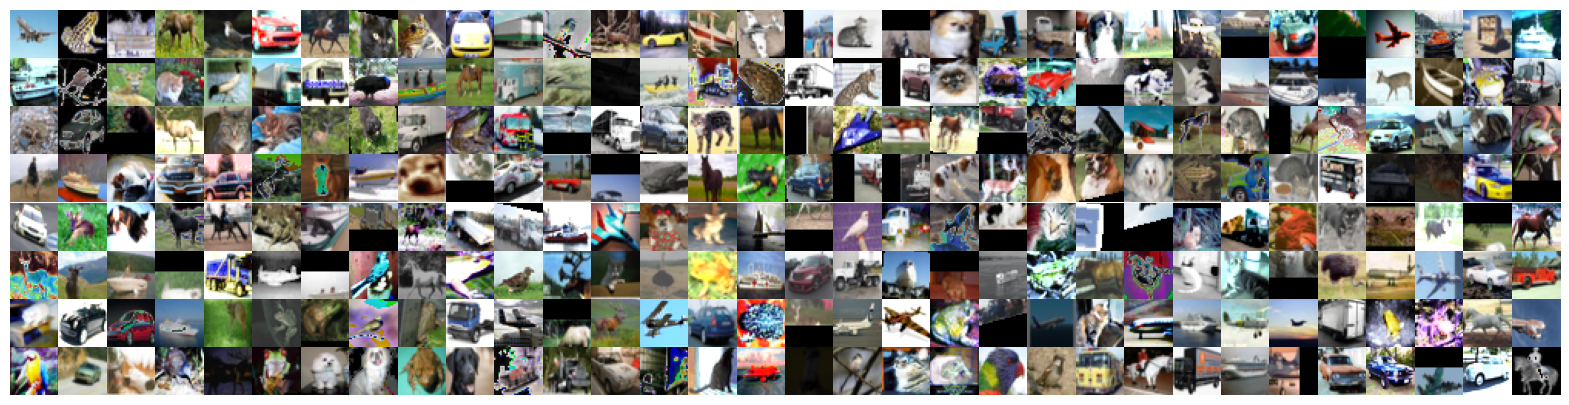

airplane	frog	truck	deer	bird	automobile	horse	cat	frog	automobile	truck	bird	deer	automobile	airplane	airplane	airplane	cat	horse	dog	truck	truck	dog	deer	airplane	ship	automobile	frog	airplane	ship	truck	ship	
0	6	9	4	2	1	7	3	6	1	9	2	4	1	0	0	0	3	7	5	9	9	5	4	0	8	1	6	0	8	9	8	

ic| features.size(): torch.Size([256, 3, 32, 32])
ic| labels.size(): torch.Size([256])


In [6]:
def trainEpoch(model:nn.Module, dataloader:DataLoader, optimizer:torch.optim, freezeModel=False) -> tuple[float, float]:
    
    """
    Trains a given model for a single epoch when given a model, dataloader, and optimizer.
    
    Arguments:
        model: The model to be evaluated or trained
        dataloader: A dataloader for either a training, validation, or test dataset
        optimizer: The current optimizer being used during training
        freezeModel: Whether or not to freeze the model for the current epoch. We want to freeze the model when running 
            inference on validation or test datasets.

    Returns:
        (modelLoss, modelAccuracy):
            modelLoss: The average model loss across the given dataset
            modelAccuracy: The average model accuracy
    """

    
    lossFunction = nn.CrossEntropyLoss()
    
    totalLoss = 0
    
    N = 0
    correct = 0
    
    for features, labels in dataloader:
        x, y = features.to(device), labels.to(device)

        if not freezeModel:
            optimizer.zero_grad()
            
        forwardPass = model.forward(x)
        
        # This adds the current accuracy to correct which is averaged over all iterations of the epoch.
        correct += (forwardPass.argmax(dim=1) == y).float().mean().item()

        loss = lossFunction(forwardPass, y)
        totalLoss += loss.item()
        
        if not freezeModel:
            # Do gradient clipping to ensure nothing crazy is happening # TODO: Analyze gradients with and without for report
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0) # Clip gradients after calculating loss
            optimizer.step()
        
        N += 1
    
    return totalLoss / N, correct / N


visualizationTransform = tv.transforms.Compose([
    preNormalizationTransform,
    # Don't normalize yet since we want to see the unnormalized augmentations first
    # v2.Normalize(mean=mean, std=std),
])



# Create dataset instances
fullDataset = CIFAR10Dataset(rootDirectory='cifar-10', csvFilename='trainLabels.csv', dataFolder='train', transform=None)
TRAIN_DATASET, VALIDATION_DATSET, TEST_DATSAET = random_split(fullDataset, [0.8, 0.1, 0.1])

# Set TRAIN_DATASAET to use the define training transform while the val and test datasets have the default transform
TRANSFORMABLE_TRAIN_DATASET = TransformableSubset(TRAIN_DATASET, transform=visualizationTransform, fullDataset=fullDataset)

BATCH_SIZE = 256
trainLoader = DataLoader(TRANSFORMABLE_TRAIN_DATASET, batch_size=BATCH_SIZE, shuffle=True)
validationLoader = DataLoader(VALIDATION_DATSET, batch_size=BATCH_SIZE, shuffle=False)

showDatasetSamples(trainLoader, fullDataset)


### Initialize actual dataset to be used

In [7]:
finalTransform = tv.transforms.Compose([
    visualizationTransform,
    # Normalize before creating the real dataset
    v2.Normalize(mean=mean, std=std),
])

# Create dataset instances
fullDataset = CIFAR10Dataset(rootDirectory='cifar-10', csvFilename='trainLabels.csv', dataFolder='train', transform=None)
TRAIN_DATASET, VALIDATION_DATSET, TEST_DATSAET = random_split(fullDataset, [0.8, 0.1, 0.1])

# Set TRAIN_DATASAET to use the define training transform while the val and test datasets have the default transform
TRANSFORMABLE_TRAIN_DATASET = TransformableSubset(TRAIN_DATASET, transform=finalTransform, fullDataset=fullDataset)

BATCH_SIZE = 256
trainLoader = DataLoader(TRANSFORMABLE_TRAIN_DATASET, batch_size=BATCH_SIZE, shuffle=True)
validationLoader = DataLoader(VALIDATION_DATSET, batch_size=BATCH_SIZE, shuffle=False)

In [8]:

torch.cuda.empty_cache()

EPOCHS = 80
RUN = '1-fc2'
RUNS_DIR = 'runs'

WARMUP_EPOCHS = 6

# TODO: Change this to SGD or RMSProp or Nesterov SGD?
# TODO: Alter learning rate schedule for best performance
lr = 1e-3
gamma = 0.9
momentum = 0.8
model = ResidualCNN(network=fc2).to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=momentum)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Warmup scheduler TODO: Look at ReduceLROnPlateu
warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1e-9, end_factor=1, total_iters=WARMUP_EPOCHS)
mainScheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

schedulers = [warmup, mainScheduler]
scheduler = torch.optim.lr_scheduler.ChainedScheduler(schedulers)



writer = SummaryWriter(f'{RUNS_DIR}/run{RUN}_batch{BATCH_SIZE}_lr{lr:0.6f}_momentum{momentum:0.4f}', flush_secs=10)

pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    trainLoss, trainAccuracy = trainEpoch(model=model, dataloader=trainLoader, optimizer=optimizer)
    validationLoss, validationAccuracy = trainEpoch(model=model, dataloader=validationLoader, optimizer=optimizer, freezeModel=True)

    # Write values to progress bar and save for tensorboardX
    pbar.set_description("lr: {:.6f}, trainLoss: {:.4f}, trainAccuracy: {:.4f}, validationLoss: {:.4f}, validationAccuracy: {:.4f}".format(scheduler.get_last_lr()[0], trainLoss, trainAccuracy, validationLoss, validationAccuracy), refresh=True)
    writer.add_scalar('trainLoss', trainLoss, epoch)
    writer.add_scalar('trainAccuracy', trainAccuracy, epoch)
    
    writer.add_scalar('validationLoss', validationLoss, epoch)
    writer.add_scalar('validationAccuracy', validationAccuracy, epoch)
    
    writer.add_scalar('lr', scheduler.get_last_lr(), epoch)

    scheduler.step()



# pbar = tqdm(range(EPOCHS))
# for epoch in pbar:
#     train_loss, train_acc = trainEpoch(model=model, dataloader=trainLoader, optimizer=optimizer)
#     # val_loss, val_acc = self.val_epoch()
#     # self.writer.add_scalar('lr', self.lr_schedule.get_last_lr(), epoch)
#     # self.writer.add_scalar('val_acc', val_acc, epoch)
#     # self.writer.add_scalar('val_loss', val_loss, epoch)
#     # self.writer.add_scalar('train_acc', train_acc, epoch)
#     writer.add_scalar('train_loss', train_loss, epoch)
#     # pbar.set_description("val acc: {:.4f}, train acc: {:.4f}".format(val_acc, train_acc), refresh=True)
#     # if val_acc > best_val_acc:
#     #     best_val_acc = val_acc
#     #     best_epoch = epoch
#     #     torch.save(self.model.state_dict(), model_file_name)
#     # self.lr_schedule.step()
#     scheduler.step()




  0%|          | 0/80 [00:00<?, ?it/s]

lr: 0.000387, trainLoss: 2.1464, trainAccuracy: 0.1777, validationLoss: 2.0876, validationAccuracy: 0.1964:  12%|█▎        | 10/80 [08:08<57:02, 48.90s/it]


KeyboardInterrupt: 